<a href="https://colab.research.google.com/github/Fedryus/Ejercicios-IA/blob/master/AtaqueAdversario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Imagenet->1000 categorias 

In [2]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
# CARGAMOS EL MODELO INCEPTION V3

from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [4]:
iv3 = InceptionV3()


In [5]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
#IV3 tiene 23 millones de parametros. Cuantos mas parametros necesitamos mas datos para que se entrene bien

In [35]:
# PROBAMOS SI IV3 FUNCIONA TAL COMO ES

from keras.preprocessing import image

#Como quiero trabajar con datos numericos (que la imagen este representada por un tensor) voy a usar img_to_array
x= image.img_to_array(image.load_img("/content/hackedAdv.png", target_size=(299,299)))



#Para meter la imagen en IV3 necesitamos que la imagen tenga unos requisitos determinados
#Por ejemplo: la imagen debe tener una proporcion de 299x299, para eso arriba uso target_size

#Cada uno de los numeros de la matriz representa el valor de c/u de los pixeles (su intensidad)
#que va de 0 a 255, pero IV3 utiliza un formato de -1 a 1. Por ende tengo que rescalar el rango de intensidad
#Para eso hago 1)x/255 (entre 0 y 1) 2)x-0.5 (entre -0.5 y 0.5) 3)x*2
x/=255
x-=0.5
x*=2
#IV3 ademas nos pide pasar un Tensor casi igual a x con 4 dimensiones, en la cual la 1ra dimension
#hace referencia al tamaño del lote (por si quiero pasarle + de una imagen)
#es una dimension que debo incluir


x= x.reshape([1, x.shape[0],x.shape[1],x.shape[2]])

print(x.shape) # 4 dimensiones: lote, altura, anchura, profundidad de los pixeles (3 por RGB)

#Toda esta informacion de como pasarle el input esta en la pagina del modelo y la documentacion

y= iv3.predict(x) 

print(y.shape) #es (1,1000) porque son 1000 probabilidades diferentes para la fila. La mas alta es el resultado
#Para encontrar la mas alta uso decode_predictions (eso que importe al principio)

decode_predictions(y)
#It works!

(1, 299, 299, 3)
(1, 1000)


[[('n07749582', 'lemon', 0.99585223),
  ('n07747607', 'orange', 0.0010086397),
  ('n04509417', 'unicycle', 0.00025801783),
  ('n02100583', 'vizsla', 0.00016297144),
  ('n03792782', 'mountain_bike', 0.00011290242)]]

In [0]:
#Ahora toca romperlo :)

**Ataques Adversarios**

Realizo un proceso de optimizacion sobre los pixeles de la imagen de entrada (en lugar de con los parametros de la nn) para MAXIMIZAR el error

In [16]:
#Primero vamos a sacar los nodos de input y output, las capas

inp_layer= iv3.layers[0].input
out_layer= iv3.layers[-1].output


print(inp_layer) #devuelve el tensor

Tensor("input_1:0", shape=(?, 299, 299, 3), dtype=float32)


In [0]:
#Queremos que la nn detecte al caballo como un limon (clase 951)
#Tenemos que decirle que elemento queremos que maximice, y ese elemento es la probabilidad de esa clase

In [0]:
target_class=951

loss= out_layer[0,target_class] #funcion de coste que tenga la probabilidad de la clase a maximizar

#Ahora tenemos que encontrar el gradiente (pero no el los param. sino en la imagen)
grad = K.gradients(loss,inp_layer)[0] #calcula el gradiente entre el error y la variable de entrada
#tendriamos dentro de grad un tensor cuyos valores nos dicen en que proporcion hay que variar los pixeles de la imagen para que poco a poco la f. de coste se vaya optimizando

In [0]:
#Creamos una funcion iterativa que compute esta operacion del gradiente 

In [28]:
optimize_gradient= K.function([inp_layer, K.learning_phase()], [grad, loss])

adv= np.copy(x)

pert=0.01 #perturbacion de la imagen

max_pert=x+0.01
min_pert=x-0.01

lemoncost=0.0

while lemoncost<0.95:
  gr, lemoncost= optimize_gradient([adv,0]) #0==modo testing
  
  adv +=gr

  adv= np.clip(adv, min_pert,max_pert) #satura los pixeles entre esos 2 valores para que sea imperceptible (no te pases de esos 2 valores)
  adv= np.clip(adv,-1,1)
  print(lemoncost)

hacked= np.copy(adv)


0.0016052303
0.0018388891
0.002123625
0.002473364
0.002935272
0.0035527537
0.0043733045
0.0055189026
0.007265925
0.010085711
0.015770352
0.029701477
0.08217258
0.4234158
0.88006485
0.96949065


In [0]:
#hay que revertir los valores que achicamos para meter en iv3
adv/=2
adv+=0.5
adv*=255



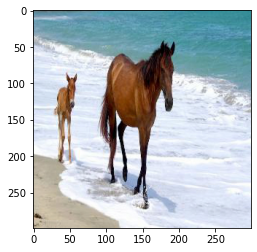

In [30]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
from PIL import Image
im= Image.fromarray(adv[0].astype(np.uint8))
im.save("/content/hacked.png")